Universidad del Valle de Guatemala - 22/07/2022

Jose Abrahama Gutierrez Corado - 19111 <br>
Walter Danilo Saldaña - 19897 <br>
Javier Alejandro Cotto Argueta -19324


# Laboratorio 2
## Series de tiempo
______________________________________________________


Importar módulos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns
from multiprocessing import cpu_count
from joblib import delayed
from prophet import *

import import_ipynb
from TS import *

/home/walt/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


importing Jupyter notebook from TS.ipynb


## Carga de datos

In [2]:
df = pd.read_csv('./GlobalLandTemperaturesByCountry.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


Se necesita cambiar el tipo de dato de la variable tiempo del dataframe a tipo "datetime"

In [3]:
df.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object

In [4]:
df['dt'] = pd.DatetimeIndex(df['dt'])
df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
Country                                  object
dtype: object

## 1. Análisis exploratorio

### Descripción del dataset
Representa las temperaturas promedio mensuales, desde 1750, para muchos lugares del mundo. El documento de donde se extrajo la información lo puede encontrar en el siguiente vínculo: http://berkeleyearth.org/data/

### Detalle de las variables

|Variable                      |Detalle|Clasificación|
|:-----------------------------|:------|:------------|
|dt                            |Date time. Mes y año de la medición|Cualitativa ordinal|
|AverageTemperature            |Temperatura promedio en el mes y año indicado por dt|Cuantitativa continua|
|AverageTemperatureUncertainty |Incertidumbre de la medición de temperatura|Cuantitativa continua|
|Country                       |País dónde se realizó la medición|Cualitativa nominal|


### Resúmen estadístico del dataset

In [5]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,1.019057
std,10.953966,1.201930
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.206000
max,38.842000,15.003000


### Limpieza de datos
#### Datos incompletos
Las series de datos que no tienen valor para la variable `AverageTemperature` no aportan información para el análisis, por lo cual se descartan.

In [6]:
df['AverageTemperature'].isnull().sum()

32651

In [7]:
df = df.dropna(subset=['AverageTemperature'])
df['AverageTemperature'].isnull().sum()

0

A fines prácticos se aproximará a 0 la incertidumbre (`AverageTemperatureUncertainty`) de las filas que no tengan información de la misma.

In [8]:
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].fillna(0)
df['AverageTemperatureUncertainty'].isnull().sum()

0

#### Datos atípicos
Se analizan los datos atípicos de la variable `AverageTemperature`.

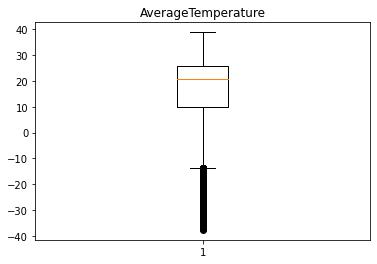

In [9]:
plt.boxplot(df['AverageTemperature'])
plt.title('AverageTemperature')
plt.show()

In [10]:
Q1 = df['AverageTemperature'].quantile(0.25)
Q3 = df['AverageTemperature'].quantile(0.75)
IQR = Q3 - Q1

inferior = df[df['AverageTemperature'] < (Q1 - 1.5 * IQR)]
superior = df[df['AverageTemperature'] > (Q3 + 1.5 * IQR)]

In [11]:
len(inferior)

6438

In [12]:
len(superior)

0

Dada la naturaleza del dataset y al ser medidas climáticas, se espera que los datos atípicos sí aporten información significatica al análisis, por lo que no hay necesidad de eliminarlos.

Se analizan los datos atípicos de la variable `AverageTemperatureUncertainty`.

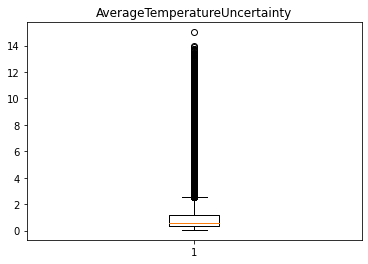

In [13]:
plt.boxplot(df['AverageTemperatureUncertainty'])
plt.title('AverageTemperatureUncertainty')
plt.show()

In [14]:
Q1 = df['AverageTemperatureUncertainty'].quantile(0.25)
Q3 = df['AverageTemperatureUncertainty'].quantile(0.75)
IQR = Q3 - Q1

inferior = df[df['AverageTemperatureUncertainty'] < (Q1 - 1.5 * IQR)]
superior = df[df['AverageTemperatureUncertainty'] > (Q3 + 1.5 * IQR)]

In [15]:
len(inferior)

0

In [16]:
len(superior)

48207

Para el caso de esta variable, si se hace notar la importancia de eliminar los datos atípicos, pues el extremo superior indica que hay varios datos con mediciones muy imprecisas, los cuales pueden distorsionar el análisis.

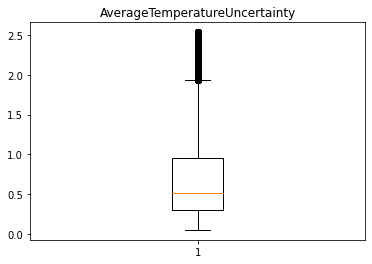

In [17]:
df.drop(superior.index, inplace=True)
    
plt.boxplot(df['AverageTemperatureUncertainty'])
plt.title('AverageTemperatureUncertainty')
plt.show()

### Comportamiento de datos

#### Normalidad de los datos

In [18]:
def show_normality(data):
    mu, std = norm.fit(data)
    plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
  
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()
    
    kurtosis = data.kurtosis()
    skew = data.skew()
    print('Kurtosis: ', kurtosis)
    print('Sesgo: ', skew)

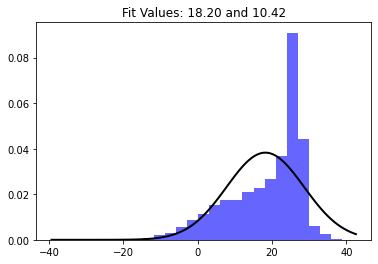

Kurtosis:  1.3855022552328835
Sesgo:  -1.2227423931132673


In [19]:
show_normality(df['AverageTemperature'])

No se puede aproximar la variable de `AverageTemperature` a una distribución normal.

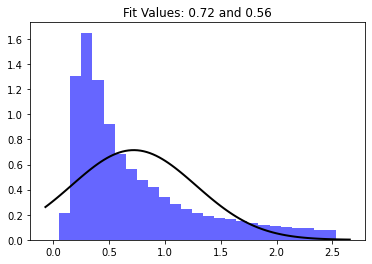

Kurtosis:  1.0329705116182009
Sesgo:  1.3416322002714294


In [20]:
show_normality(df['AverageTemperatureUncertainty'])

La variable de `AverageTemperatureUncertainty` tampoco cumple para una distribución normal.

#### Correlación de los datos

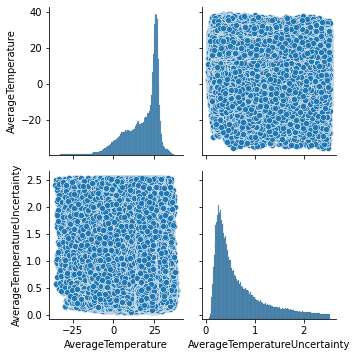

In [21]:
sns.pairplot(data=df)

<AxesSubplot:>

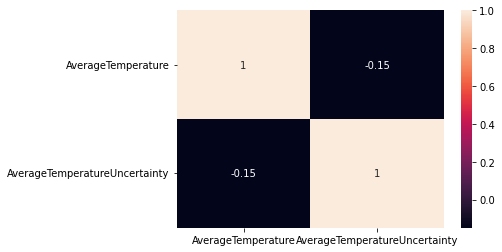

In [22]:
correlacion = df[['AverageTemperature', 'AverageTemperatureUncertainty']].corr()
fig, axis = plt.subplots()
sns.heatmap(correlacion, xticklabels=correlacion.columns, yticklabels=correlacion.columns, annot=True, ax=axis)

Se puede observar que no hay correlación entre las variables númericas estudiadas.

#### Lugares con temperaturas más extremas

In [23]:
avg_temp_by_country = df.groupby('Country').mean()\
    .sort_values(by=['AverageTemperature'])

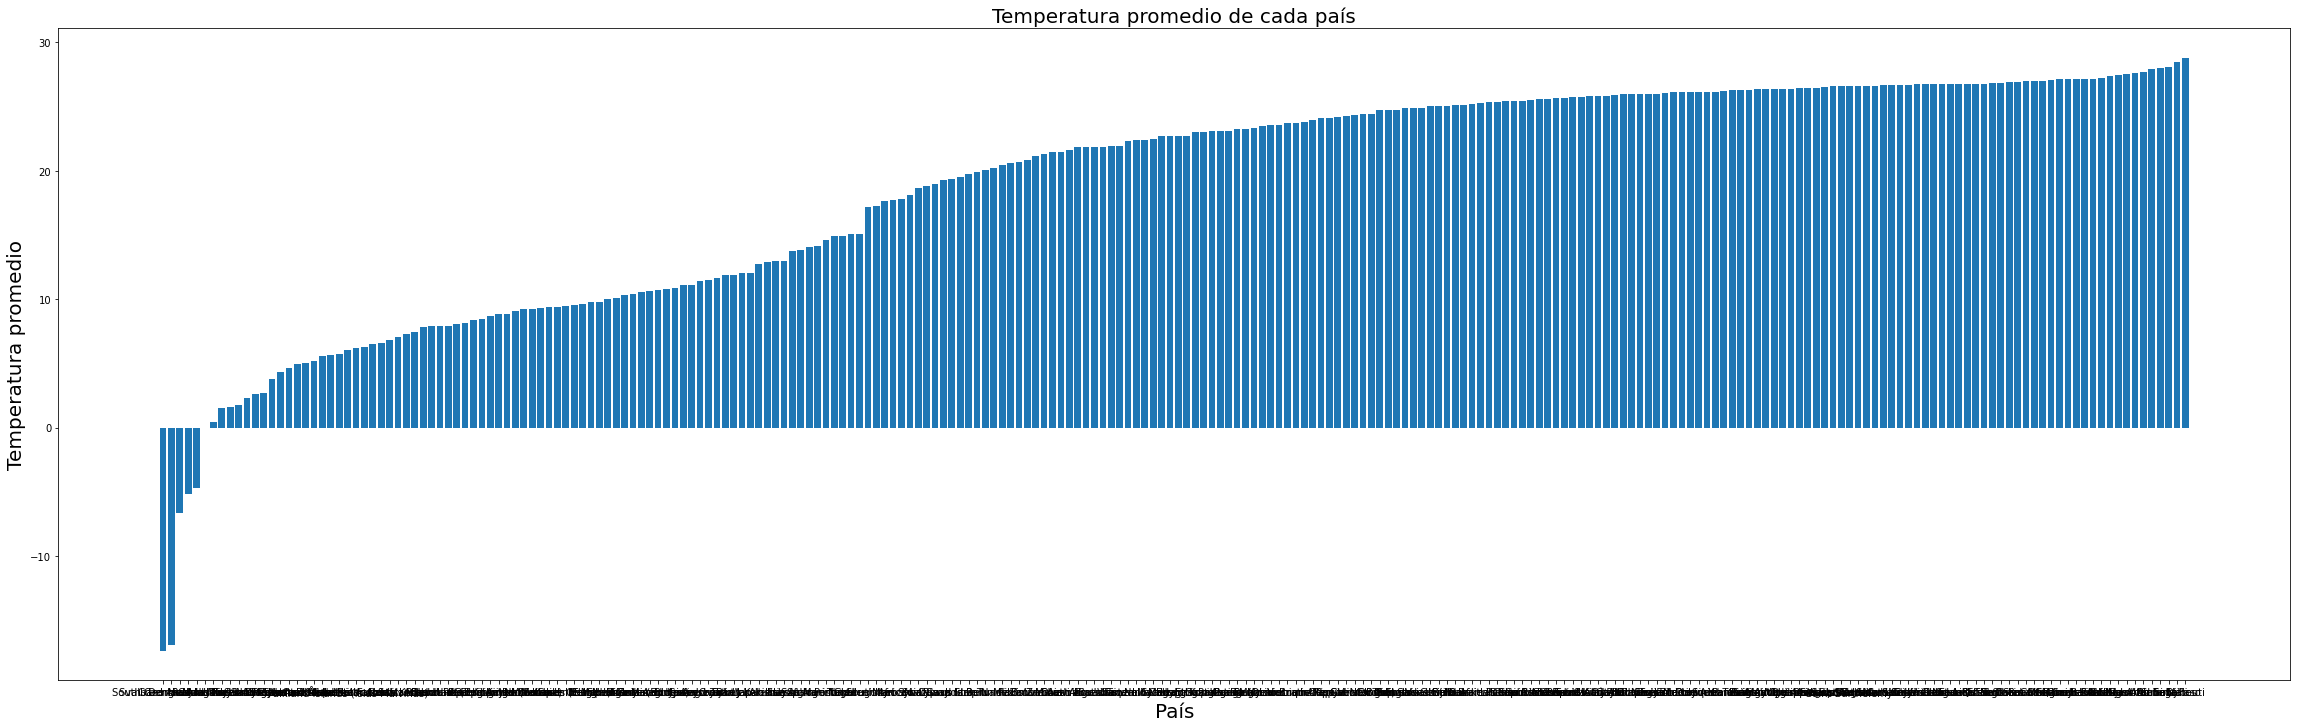

In [24]:
plt.figure(figsize=(40,12))
plt.bar(
    avg_temp_by_country.index,
    avg_temp_by_country['AverageTemperature']
)
plt.title('Temperatura promedio de cada país', size=20)
plt.xlabel('País', size=20)
plt.ylabel('Temperatura promedio', size=20)
plt.show()

Top 5 lugares con temperaturas más bajas:

In [25]:
avg_temp_by_country.head()

,AverageTemperature,AverageTemperatureUncertainty
Country,,
Greenland,-17.382228,1.251991
Denmark,-16.928744,1.227067
Svalbard And Jan Mayen,-6.653556,1.072731
Russia,-5.179728,0.890896
Canada,-4.682512,0.943881


Top 5 lugares con temperaturas más altas:

In [26]:
avg_temp_by_country.tail()

,AverageTemperature,AverageTemperatureUncertainty
Country,,
Aruba,27.924171,0.633795
Senegal,27.984304,0.672733
Burkina Faso,28.085516,0.694007
Mali,28.444861,0.772745
Djibouti,28.815201,0.860161


De lo más destacable en este punto es que los países más calurosos no difieren de forma extrema a la temperatura promedio del resto de países. Por el otro lado, los países más frios son más escasos, y con temperaturas más extremas en comparación a los demás.

## 2. Serie univariante por la variable AverageTemperature

### a. Especifique Inicio, fin, y frecuencia.

- **Inicio**: Año 2000, debido a que conocemos que en los últimos años la temperatura ha incremendado a un ritmo sin precedentes, por lo que la información de años anteriores ya no resulta muy útil.
- **Fin**: 2013 (año más reciente con datos disponibles)
- **Frecuencia**: Mensual

In [50]:
temp_serie = df[['dt', 'AverageTemperature']]\
    .loc[df['dt'] > '2000']
temp_serie

,dt,AverageTemperature
3075,2000-02-01,-0.023
3076,2000-03-01,0.615
3077,2000-04-01,4.124
3078,2000-05-01,8.557
3079,2000-06-01,11.742
...,...,...
577456,2013-04-01,21.142
577457,2013-05-01,19.059
577458,2013-06-01,17.613
577459,2013-07-01,17.000


### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

In [51]:
temp_serie = temp_serie[['dt', 'AverageTemperature']].groupby('dt').mean()

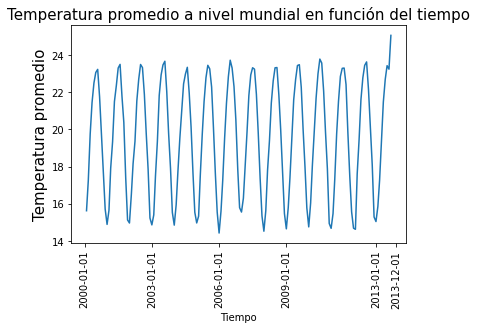

In [54]:
plt.plot(
    temp_serie.index,
    temp_serie['AverageTemperature']
)
plt.title('Temperatura promedio a nivel mundial en función del tiempo', size=15)
plt.xlabel('Tiempo')
plt.ylabel('Temperatura promedio', size=15)
plt.xticks(
    ['2000-01-01', '2003-01-01', '2006-01-01', '2009-01-01', '2013-01-01', '2013-12-01'],
    rotation=90
)
plt.show()

Tomando los datos en el rango y frecuencia estimada, podemos observar que los datos de comportan de forma estacional. Sin embargo, también se nota el detalle que el patrón se rompe a mediados del año 2013, dónde se ve un incremento inusual de la temperatura en su punto máximo.

### c. Descomponga la serie en sus componentes. Teniendo en cuenta el diagrama de la serie y sus componentes discuta si es posible hablar de estacionalidad.

Efecctivamente se nota que existe estacionalidad en la serie de tiempo, el patrón se repite cada año de forma cíclica, el cual es el segundo componente que se puede apreciar en la gráfica, la ciclisidad de los datos.

### d. Determine si es necesario transformar la serie. Explique.

Las suposiciones de temperatura establecidas en el enálisis exploratorio de este documentose cumplen en la serie de tiempo anteriormente descrita, por lo tanto no es necesario realizar transformaciones a la serie.

### e. Una   vez   analizada   la   serie,   elija   los  parámetros   p,   q   y   d   del   modelo   ARIMA   o SARIMA 

In [55]:
p = 1
q = 1
d = 0 # ya es estacionaria

### f. Haga varios modelos SARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie.

Se utilizará SARIMA dado que se encontró estacionalidad en los datos.

Tamaño Entrenamiento 132
Tamaño Prueba 32
Encontrando la mejor solución para promedio
 > Modelo[1, 'promedio'] 1.645 > Modelo[1, 'mediana'] 1.645 > Modelo[2, 'promedio'] 2.321
 > Modelo[2, 'mediana'] 2.321 > Modelo[3, 'promedio'] 2.931 > Modelo[4, 'promedio'] 3.438



 > Modelo[7, 'mediana'] 4.485 > Modelo[5, 'promedio'] 3.824
 > Modelo[4, 'mediana'] 3.586 > Modelo[5, 'mediana'] 4.112 > Modelo[7, 'promedio'] 4.194 > Modelo[3, 'mediana'] 3.042 > Modelo[6, 'mediana'] 4.358 > Modelo[6, 'promedio'] 4.078
 > Modelo[8, 'mediana'] 4.581





 > Modelo[8, 'promedio'] 4.175 > Modelo[9, 'promedio'] 4.036 > Modelo[9, 'mediana'] 4.640 > Modelo[10, 'promedio'] 3.799

 > Modelo[11, 'promedio'] 3.513
 > Modelo[11, 'mediana'] 3.391 > Modelo[10, 'mediana'] 4.119


 > Modelo[12, 'promedio'] 3.231 > Modelo[12, 'mediana'] 3.231



 > Modelo[13, 'mediana'] 3.097 > Modelo[16, 'mediana'] 3.000 > Modelo[17, 'mediana'] 3.342 > Modelo[14, 'mediana'] 2.658 > Modelo[19, 'mediana'] 3.843 > Modelo[20, 'mediana'] 3.

 > Modelo[124, 'promedio'] 3.191 > Modelo[128, 'mediana'] 3.214 > Modelo[112, 'mediana'] 3.189 > Modelo[116, 'promedio'] 3.274



 > Modelo[120, 'mediana'] 3.199
 > Modelo[131, 'promedio'] 3.243 > Modelo[128, 'promedio'] 3.268 > Modelo[112, 'promedio'] 3.189


 > Modelo[120, 'promedio'] 3.221
 > Modelo[132, 'mediana'] 3.200
 > Modelo[132, 'promedio'] 3.221
terminado
[1, 'mediana'] 1.645143484813968
[1, 'promedio'] 1.645143484813968
[2, 'mediana'] 2.320620463191907


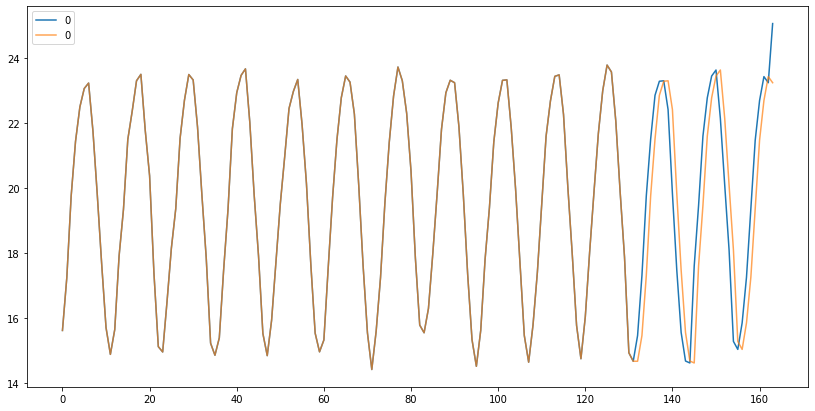

In [56]:
encontrar_mejor_solucion(temp_serie, 'TS Temperatura', metodo = "promedio")

### g. Haga un modelo usando el algoritmo Prophet de Facebook. Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

Prophet tambien necesita que los nombres se cambien, la variable de tiempo al nombre "ds" y la variable a predecir a "y".

In [57]:
df1 = df.rename(columns={'dt': 'ds',
                        'AverageTemperature': 'y'})
df1.head()

,ds,y,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland
10,1744-09-01,11.702,1.517,Åland


Instanciamos un objeto de la Clase Prophet

In [58]:
# Fijamos un intervalo de incertidumbre de 0.95
model = Prophet(interval_width = 0.95)

Ajustamos el módelo

In [59]:
model.fit(df1)

11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing


## 3. Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción.

In [60]:
temp_s1 = df1.loc[df1["ds"].between('2011-01-1', '2013-12-31')]
temp_s1

,ds,y,AverageTemperatureUncertainty,Country
3206,2011-01-01,-1.959,0.461,Åland
3207,2011-02-01,-6.390,0.454,Åland
3208,2011-03-01,-0.311,0.249,Åland
3209,2011-04-01,4.804,0.716,Åland
3210,2011-05-01,8.603,0.457,Åland
...,...,...,...,...
577456,2013-04-01,21.142,0.495,Zimbabwe
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe


In [61]:
prediccion = model.predict(temp_s1)

In [62]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,14.550794,-5.755011,33.471889
1,2011-01-01,14.550794,-4.027474,33.719826
2,2011-01-01,14.550794,-5.163273,35.151107
3,2011-01-01,14.550794,-6.244271,32.456014
4,2011-01-01,14.550794,-4.702636,32.391429


## 4. Haga una predicción, tres años al futuro, usando los años anteriores y determine qué tan apegada es a la realidad teniendo en cuenta los meses pasados del año actual.

In [63]:
model2 = Prophet(interval_width = 0.95)
model2.fit(temp_s1)

11:58:39 - cmdstanpy - INFO - Chain [1] start processing
11:58:40 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
fechas_futuras = model2.make_future_dataframe(periods=36, freq='MS')
fechas_futuras.tail()

,ds
64,2016-05-01
65,2016-06-01
66,2016-07-01
67,2016-08-01
68,2016-09-01


In [65]:
prediccion = model2.predict(fechas_futuras)

In [66]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
64,2016-05-01,21.705379,2.479366,42.051460
65,2016-06-01,22.901311,3.184778,42.786584
66,2016-07-01,23.625598,3.500206,44.053322
67,2016-08-01,23.643457,4.482188,42.599367
68,2016-09-01,22.393904,2.932431,40.900258


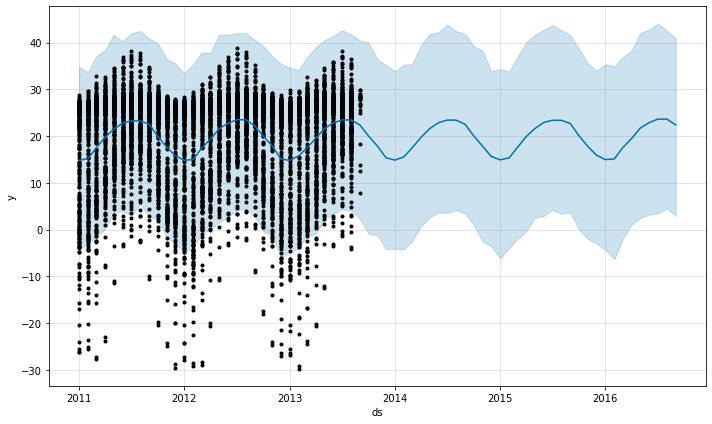

In [67]:
model2.plot(prediccion,
               uncertainty=True);

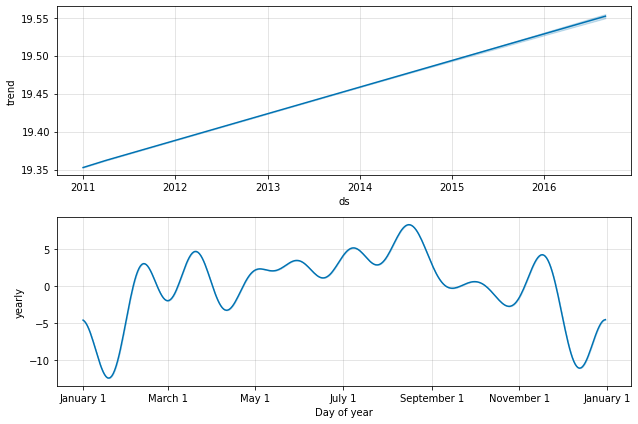

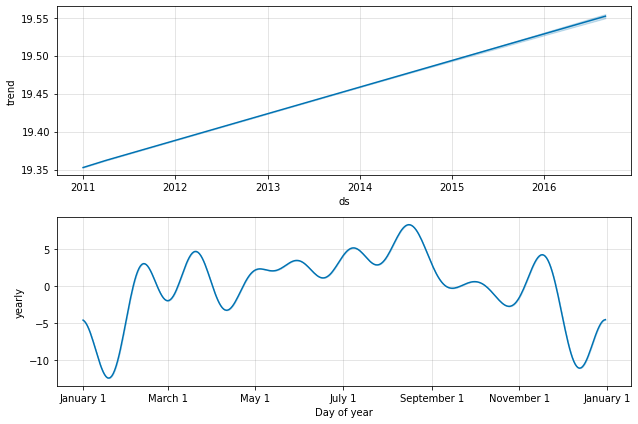

In [68]:
model2.plot_components(prediccion)

## 5. Basado en los resultados obtenidos, diría Ud que hay evidencia para corroborar la tan discutida aseveración de que el Cambio Climático y el Calentamiento Global es real